# **1. Introduction**

## 1.1 Project Overview

This project focuses on building a **movie recommendation system** using traditional machine learning techniques. The goal is to predict how a user would rate a movie they haven’t rated before, based on:  
- **Historical user-movie ratings**  
- **Trust relationships between users**  

## 1.2 Dataset Overview



`train_data_movie_rate.csv` – User-Movie Ratings  
Contains explicit ratings given by users to movies.  

| Column | Description |  
|--------|------------|  
| `user_id` | Unique identifier for each user |  
| `item_id` | Unique identifier for each movie |  
| `label` | Numerical rating (e.g., 1-5) |  

**Use:** Train the model to predict missing ratings.  

`train_data_movie_trust.csv` – User-User Trust Relationships**  
Indicates how much one user trusts another (useful for collaborative filtering).  

| Column | Description |  
|--------|------------|  
| `user_id_trustor` | User who gives trust |  
| `user_id_trustee` | User who receives trust |  
| `trust_value` | Strength of trust (e.g., 0-1) |  

**Use:** Enhance recommendations by considering trusted users' preferences.  


# **2. Environment Setup**

## 2.1 Import Libraries

In [119]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge

## 2.2 Configuration

In [107]:
RANDOM_SEED = 42
TEST_SIZE = 0.2

# **3. Exploratory Data Analysis (EDA)**
Understand the structure, patterns, and relationships in the data

## 3.1 Load Data

In [ ]:
ratings_df = pd.read_csv('train_data_movie_rate.csv')

In [ ]:
ratings_df.head()

,id,user_id,item_id,label
0,1,1,1,2.0
1,2,1,2,4.0
2,3,1,3,3.5
3,4,1,4,3.0
4,5,1,5,4.0


In [ ]:
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34298 entries, 0 to 34297
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       34298 non-null  int64  
 1   user_id  34298 non-null  int64  
 2   item_id  34298 non-null  int64  
 3   label    34298 non-null  float64
dtypes: float64(1), int64(3)
memory usage: 1.0 MB


In [ ]:
trust_df = pd.read_csv('train_data_movie_trust.csv')

In [ ]:
trust_df.head()

,id,user_id_trustor,user_id_trustee,trust_value
0,1,2,966,1
1,2,2,104,1
2,3,5,1509,1
3,4,6,1192,1
4,5,7,1510,1


In [ ]:
trust_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1853 entries, 0 to 1852
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   id               1853 non-null   int64
 1   user_id_trustor  1853 non-null   int64
 2   user_id_trustee  1853 non-null   int64
 3   trust_value      1853 non-null   int64
dtypes: int64(4)
memory usage: 58.0 KB


## 3.2 Rating Dataset

### 3.2.1 Basic Info

In [ ]:
print("Ratings Dataset Info:")
print(f"Number of unique users: {ratings_df['user_id'].nunique()}")
print(f"Number of unique movies: {ratings_df['item_id'].nunique()}")
ratings_df["label"].describe()

Ratings Dataset Info:
Number of unique users: 1498
Number of unique movies: 2071


,label
count,34298.000000
mean,3.006298
std,0.915706
min,0.500000
25%,2.500000
50%,3.000000
75%,4.000000
max,4.000000


### 3.2.2 Rating Distribution

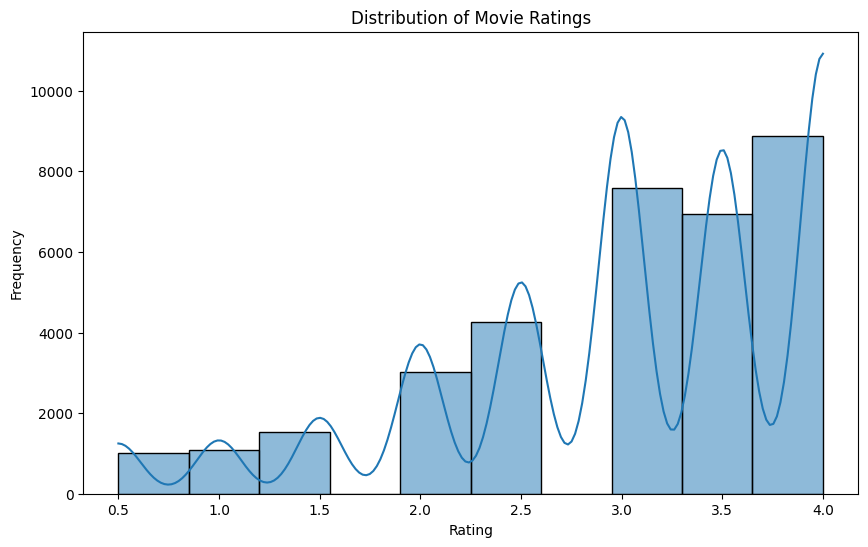

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(ratings_df['label'], bins=10, kde=True)
plt.title('Distribution of Movie Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

### 3.2.3 Movies Rating

In [ ]:
movie_stats = ratings_df.groupby('item_id')['label'].agg(['mean', 'count'])
print("\nTop 5 Highest Rated Movies (min 10 ratings):")
display(movie_stats[movie_stats['count'] >= 10].sort_values('mean', ascending=False).head())
print("\nTop 5 Most Rated Movies:")
display(movie_stats.sort_values('count', ascending=False).head())


Top 5 Highest Rated Movies (min 10 ratings):


,mean,count
item_id,,
842,3.850000,10
363,3.769231,13
286,3.750000,22
805,3.714286,35
400,3.708333,12



Top 5 Most Rated Movies:


,mean,count
item_id,,
7,3.164824,995
11,3.378603,902
2,3.190286,875
207,2.883513,837
1,2.978339,831


Text(0, 0.5, 'Average Rating')

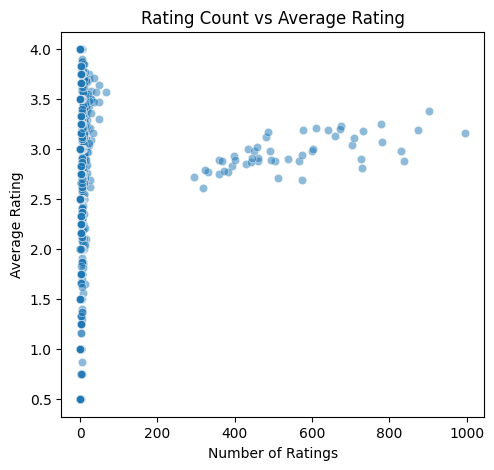

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 2)
sns.scatterplot(x='count', y='mean', data=movie_stats, alpha=0.5)
plt.title('Rating Count vs Average Rating')
plt.xlabel('Number of Ratings')
plt.ylabel('Average Rating')

### 3.2.3 User Rating Activity

In [ ]:
user_stats = ratings_df.groupby('user_id')['label'].agg(['count', 'mean', 'std'])
print("User Rating Activity Summary:")
display(user_stats)

User Rating Activity Summary:


,count,mean,std
user_id,,,
1,12,3.416667,0.668558
3,193,2.829016,1.155507
4,6,2.333333,0.983192
5,1,3.000000,NaN
6,4,3.875000,0.250000
...,...,...,...
1504,23,3.108696,0.797104
1505,36,3.291667,0.943966
1506,2,1.750000,0.353553


In [ ]:
user_stats.sort_values('count', ascending=False).head()

,count,mean,std
user_id,,,
1187,232,2.745690,0.625904
272,217,2.677419,0.845520
3,193,2.829016,1.155507
969,174,2.784483,0.727924
161,166,2.683735,1.003467


## 3.3 Trust Dataset

### 3.3.1 Basic Info

In [ ]:
print("Trust Dataset Info:")
print(f"Shape: {trust_df.shape}")
print(f"Number of unique trustors: {trust_df['user_id_trustor'].nunique()}")
print(f"Number of unique trustees: {trust_df['user_id_trustee'].nunique()}")
print(f"Trust value range: {trust_df['trust_value'].min()} to {trust_df['trust_value'].max()}")
trust_df["trust_value"].describe()

Trust Dataset Info:
Shape: (1853, 4)
Number of unique trustors: 609
Number of unique trustees: 732
Trust value range: 1 to 1


,trust_value
count,1853.0
mean,1.0
std,0.0
min,1.0
25%,1.0
50%,1.0
75%,1.0
max,1.0


### 3.3.2 Trsut Network

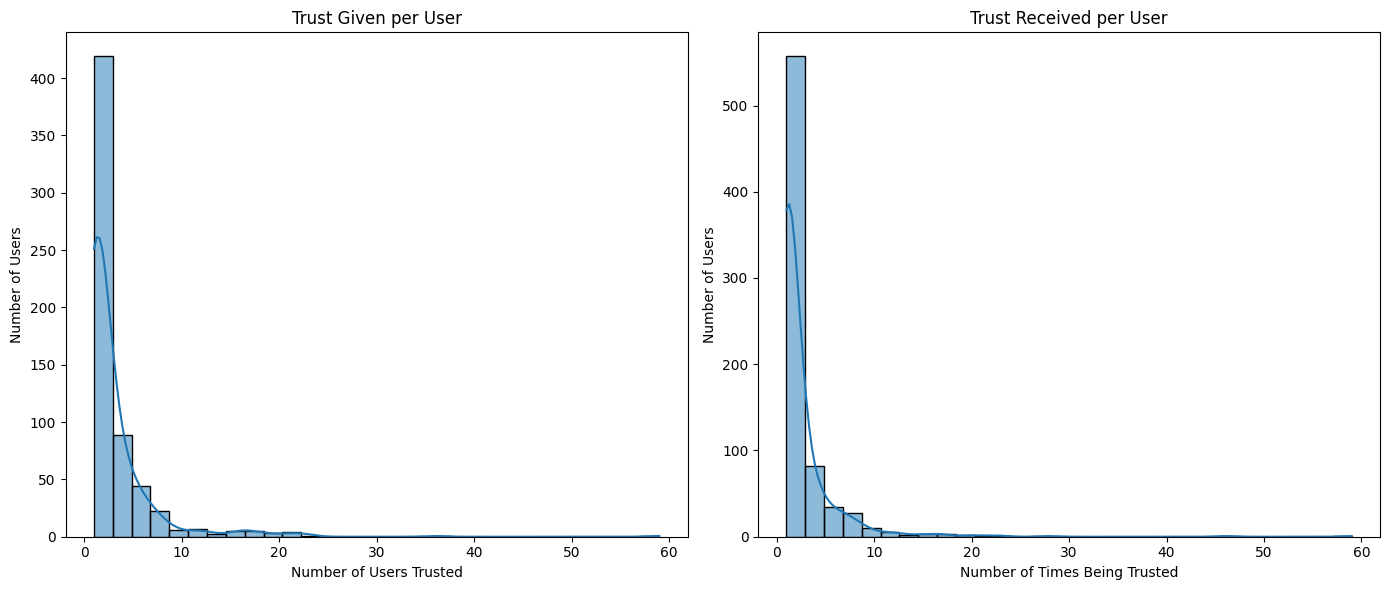

In [33]:
trust_given = trust_df.groupby('user_id_trustor').size()
trust_received = trust_df.groupby('user_id_trustee').size()

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.histplot(trust_given, bins=30, kde=True)
plt.title('Trust Given per User')
plt.xlabel('Number of Users Trusted')
plt.ylabel('Number of Users')

plt.subplot(1, 2, 2)
sns.histplot(trust_received, bins=30, kde=True)
plt.title('Trust Received per User')
plt.xlabel('Number of Times Being Trusted')
plt.ylabel('Number of Users')
plt.tight_layout()
plt.show()

In [ ]:
print("\nTop 5 Most Trusted Users (Trustees):")
display(trust_df['user_id_trustee'].value_counts().head())


Top 5 Most Trusted Users (Trustees):


,count
user_id_trustee,
509,59
188,46
628,28
1398,23
29,22


# **4. Preprocess Data and Feature Enginerring**

In [ ]:
copy_ratings_df = ratings_df.copy()

In [ ]:
copy_trust_df = trust_df.copy()

## 4.1 Handling Missing Values

In [ ]:
copy_ratings_df.isnull().sum()

,0
id,0
user_id,0
item_id,0
label,0


In [ ]:
copy_trust_df.isnull().sum()

,0
id,0
user_id_trustor,0
user_id_trustee,0
trust_value,0


## 4.2 Check Data Inconsistency

### 4.2.1 Remove Duplicate

In [ ]:
duplicates = copy_ratings_df.duplicated(subset=['user_id', 'item_id'], keep=False)

print(f"Found {duplicates.sum()} duplicate user-item ratings")
display(copy_ratings_df[duplicates].sort_values(['user_id', 'item_id']).head() if duplicates.any() else "No duplicates found")

if duplicates.any():
    print("\nKeeping last rating for duplicate user-item pairs...")
    copy_ratings_df = copy_ratings_df.sort_values(['user_id', 'item_id', 'label'])
    copy_ratings_df = copy_ratings_df.drop_duplicates(subset=['user_id', 'item_id'], keep='last')
    print(f"Remaining ratings: {len(copy_ratings_df)}")

Found 6 duplicate user-item ratings


,id,user_id,item_id,label
6358,6359,308,12,4.0
6433,6434,308,12,4.0
6355,6356,308,207,3.5
6381,6382,308,207,3.0
6356,6357,308,235,4.0



Keeping last rating for duplicate user-item pairs...
Remaining ratings: 34295


In [ ]:
duplicates = copy_trust_df.duplicated(subset=['user_id_trustor', 'user_id_trustor'], keep=False)

print(f"Found {duplicates.sum()} duplicate trust relations")
display(copy_trust_df[duplicates].sort_values(['user_id_trustor', 'user_id_trustor']).head() if duplicates.any() else "No duplicates found")

if duplicates.any():
    print("\nKeeping last trust relations for duplicate user-item pairs...")
    copy_trust_df = copy_trust_df.sort_values(['user_id_trustor', 'user_id_trustor', 'trust_value'])
    copy_trust_df = copy_trust_df.drop_duplicates(subset=['user_id_trustor', 'user_id_trustor'], keep='last')
    print(f"Remaining relations: {len(copy_trust_df)}")

Found 1564 duplicate trust relations


,id,user_id_trustor,user_id_trustee,trust_value
0,1,2,966,1
1,2,2,104,1
6,7,15,652,1
7,8,15,883,1
8,9,15,1511,1



Keeping last trust relations for duplicate user-item pairs...
Remaining relations: 609


### 4.2.2 Checking Trust Relationship Consistency

In [ ]:
self_trust = copy_trust_df[copy_trust_df['user_id_trustor'] == copy_trust_df['user_id_trustee']]
print(f"Found {len(self_trust)} self-trust relationships")
display(self_trust.head() if len(self_trust) > 0 else "No self-trust relationships found")

if len(self_trust) > 0:
    trust = copy_trust_df[copy_trust_df['user_id_trustor'] != copy_trust_df['user_id_trustee']]
    print(f"Remaining trust relationships: {len(copy_trust_df)}")

Found 0 self-trust relationships


'No self-trust relationships found'

## 4.3 Feature Engineering

### 4.3.1 User Based Features

In [89]:
user_avg_ratings = copy_ratings_df.groupby('user_id')['label'].mean().reset_index(name='user_avg_rating')

In [90]:
user_rating_count = copy_ratings_df.groupby('user_id').size().reset_index(name='user_rating_count')

In [91]:
final_df = (copy_ratings_df
            .merge(user_avg_ratings, on='user_id', how='left')
            .merge(user_rating_count, on='user_id', how='left'))

### 4.3.2 Movie Based Features

In [92]:
movie_avg_ratings = copy_ratings_df.groupby('item_id')['label'].mean().reset_index(name='movie_avg_rating')

In [93]:
movie_rating_count = copy_ratings_df.groupby('item_id').size().reset_index(name='movie_rating_count')

In [94]:
final_df = (final_df
            .merge(movie_avg_ratings, on='item_id', how='left')
            .merge(movie_rating_count, on='item_id', how='left'))

### 4.3.3 Trust Based Features

In [95]:
trust_dict = {}
for _, row in trust_df.iterrows():
    trustor = row['user_id_trustor']
    trustee = row['user_id_trustee']
    if trustor not in trust_dict:
        trust_dict[trustor] = set()
    trust_dict[trustor].add(trustee)

In [96]:
def get_trusted_avg_rating(user_id, item_id):
    if user_id not in trust_dict:
        return np.nan

    trusted_users = trust_dict[user_id]
    trusted_ratings = ratings_df[(ratings_df['user_id'].isin(trusted_users)) &
                               (ratings_df['item_id'] == item_id)]

    if len(trusted_ratings) > 0:
        return trusted_ratings['label'].mean()
    else:
        return np.nan

In [97]:
final_df['trusted_avg_rating'] = final_df.apply(
    lambda row: get_trusted_avg_rating(row['user_id'], row['item_id']),
    axis=1
)

In [98]:
final_df['trusted_avg_rating'] = final_df['trusted_avg_rating'].fillna(
    final_df['movie_avg_rating']
)

### 4.3.4 Final Features

In [106]:
feature_cols = [
    'user_avg_rating', 'user_rating_count',
    'movie_avg_rating', 'movie_rating_count',
    'trusted_avg_rating',
]

In [101]:
final_df

,id,user_id,item_id,label,user_avg_rating,user_rating_count,movie_avg_rating,movie_rating_count,trusted_avg_rating
0,1,1,1,2.0,3.416667,12,2.978339,831,2.978339
1,2,1,2,4.0,3.416667,12,3.190286,875,3.190286
2,3,1,3,3.5,3.416667,12,3.045519,703,3.045519
3,4,1,4,3.0,3.416667,12,3.192969,640,3.192969
4,5,1,5,4.0,3.416667,12,3.230030,676,3.230030
...,...,...,...,...,...,...,...,...,...
34290,34296,1508,669,1.0,2.844828,29,3.250000,4,3.250000
34291,34297,1508,686,2.5,2.844828,29,2.400000,5,3.000000
34292,34272,1508,693,3.5,2.844828,29,2.687500,8,2.000000
34293,34279,1508,751,1.0,2.844828,29,1.000000,3,0.500000


## 4.4 Split Train Test

In [108]:
X = final_df[feature_cols]
y = final_df['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_SEED
)

## 4.5 Normalization

In [112]:
rating_cols = [
    'user_avg_rating',
    'movie_avg_rating',
    'trusted_avg_rating',
]

minmax_scaler = MinMaxScaler(feature_range=(0, 1))
X_train[rating_cols] = minmax_scaler.fit_transform(X_train[rating_cols])
X_test[rating_cols] = minmax_scaler.transform(X_test[rating_cols])

In [114]:
cnt_cols = ['user_rating_count', 'movie_rating_count']

standard_scaler = StandardScaler()
X_train[cnt_cols] = standard_scaler.fit_transform(X_train[cnt_cols])
X_test[cnt_cols] = standard_scaler.transform(X_test[cnt_cols])

# **5. Recommendation System**

Develop a recommendation system using machine learning algorithms. Train the model and evaluate its performance using RMSE, MAE, MSE, R2 as metrics

## 5.1 Models

In [118]:
models = {
    "KNN": {
        "model": KNeighborsRegressor(),
        "params": {
            'n_neighbors': [3, 5, 7, 10],
            'weights': ['uniform', 'distance'],
            'metric': ['euclidean', 'manhattan']
        }
    },
    "Random Forest": {
        "model": RandomForestRegressor(random_state=42),
        "params": {
            'n_estimators': [50, 100],
            'max_depth': [None, 10, 20]
        }
    },
    "Gradient Boosting": {
        "model": GradientBoostingRegressor(random_state=42),
        "params": {
            'n_estimators': [50, 100],
            'learning_rate': [0.01, 0.1],
            'max_depth': [3, 5]
        }
    },
    "SVR": {
        "model": SVR(),
        "params": {
            'C': [0.1, 1, 10],
            'kernel': ['linear', 'rbf']
        }
    },
    "Ridge Regression": {
        "model": Ridge(),
        "params": {
            'alpha': [0.1, 1, 10]
        }
    }
}

## 5.2 Training and Evaluation

In [121]:
results = []

for model_name, config in models.items():
    print(f"\nTraining {model_name}...")

    grid = GridSearchCV(
        estimator=config["model"],
        param_grid=config["params"],
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        verbose=1
    )

    grid.fit(X_train, y_train)

    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test)

    metrics = {
        'Model': model_name,
        'Best Params': grid.best_params_,
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'MAE': mean_absolute_error(y_test, y_pred),
        'MSE': mean_squared_error(y_test, y_pred),
        'R2': r2_score(y_test, y_pred)
    }

    results.append(metrics)

    print(f"{model_name} completed. Best params: {grid.best_params_}")


Training KNN...
Fitting 5 folds for each of 16 candidates, totalling 80 fits
KNN completed. Best params: {'metric': 'manhattan', 'n_neighbors': 10, 'weights': 'uniform'}

Training Random Forest...
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Random Forest completed. Best params: {'max_depth': 10, 'n_estimators': 100}

Training Gradient Boosting...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Gradient Boosting completed. Best params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}

Training SVR...
Fitting 5 folds for each of 6 candidates, totalling 30 fits
SVR completed. Best params: {'C': 10, 'kernel': 'rbf'}

Training Ridge Regression...
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Ridge Regression completed. Best params: {'alpha': 0.1}


## 5.3 Results Comparison

In [124]:
results_df = pd.DataFrame(results)
results_df = results_df[['Model', 'RMSE', 'MAE', 'MSE', 'R2', 'Best Params']]

print("\nModel Performance Comparison:")
print(results_df.sort_values('RMSE').drop(columns=['Best Params']))


Model Performance Comparison:
               Model      RMSE       MAE       MSE        R2
2  Gradient Boosting  0.726268  0.555866  0.527466  0.359036
1      Random Forest  0.728440  0.555497  0.530625  0.355196
3                SVR  0.729033  0.550397  0.531489  0.354147
4   Ridge Regression  0.731040  0.564776  0.534420  0.350585
0                KNN  0.756500  0.580012  0.572293  0.304563


## 5.4 Visualization of Results

<Figure size 1000x600 with 0 Axes>

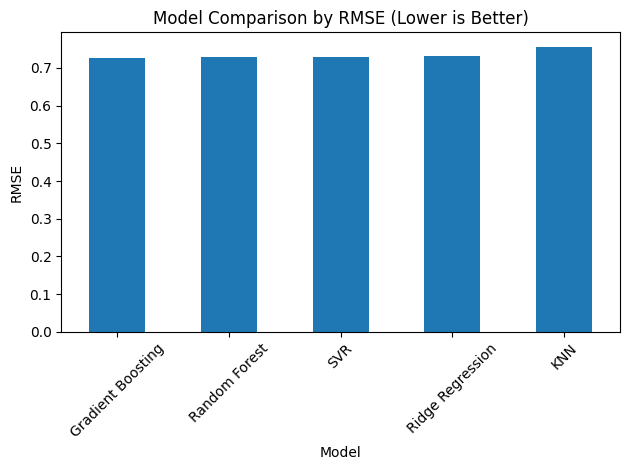

In [123]:
plt.figure(figsize=(10, 6))
results_df.sort_values('RMSE').plot(x='Model', y='RMSE', kind='bar', legend=False)
plt.title('Model Comparison by RMSE (Lower is Better)')
plt.ylabel('RMSE')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()